In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.datasets import load_boston

In [2]:
boston=load_boston()

In [3]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [4]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
df=pd.DataFrame(boston.data)
df.columns=boston.feature_names
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [6]:
df['Price']=boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [7]:
import xgboost as xgb

In [8]:
X=boston.data
y=boston.target

# Implementing the xgboost Algo

In [9]:
data_matrix=xgb.DMatrix(data=X ,label=y)
data_matrix

In [10]:
xgb.XGBRegressor?


Init signature: xgb.XGBRegressor(*, objective='reg:squarederror', **kwargs)
Docstring:     
Implementation of the scikit-learn API for XGBoost regression.


Parameters
----------

    n_estimators : int
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth : int
        Maximum tree depth for base learners.
    learning_rate : float
        Boosting learning rate (xgb's "eta")
    verbosity : int
        The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
    objective : string or callable
        Specify the learning task and the corresponding learning objective or
        a custom objective function to be used (see note below).
    booster: string
        Specify which booster to use: gbtree, gblinear or dart.
    tree_method: string
        Specify which tree method to use.  Default to auto.  If this parameter
        is set to default, XGBoost will choose the most conservative option
        available.  It's recomme

In [11]:
params = {
    'learning_rate':.1,
    'max_depth':5,
    'alpha':10,
}

In [12]:
result = xgb.cv(dtrain = data_matrix, params=params,num_boost_round=200, early_stopping_rounds=10,metrics='rmse',seed=0 )
result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,21.633839,0.304023,21.629372,0.668377
1,19.626059,0.273856,19.639051,0.655697
2,17.817540,0.244527,17.868345,0.673887
3,16.186889,0.223547,16.254699,0.657798
4,14.723644,0.198366,14.831833,0.661576
...,...,...,...,...
130,1.013244,0.050047,3.481882,0.396128
131,1.012721,0.050077,3.481993,0.395973
132,1.011574,0.050181,3.481841,0.396186
133,1.011088,0.050241,3.481868,0.396147


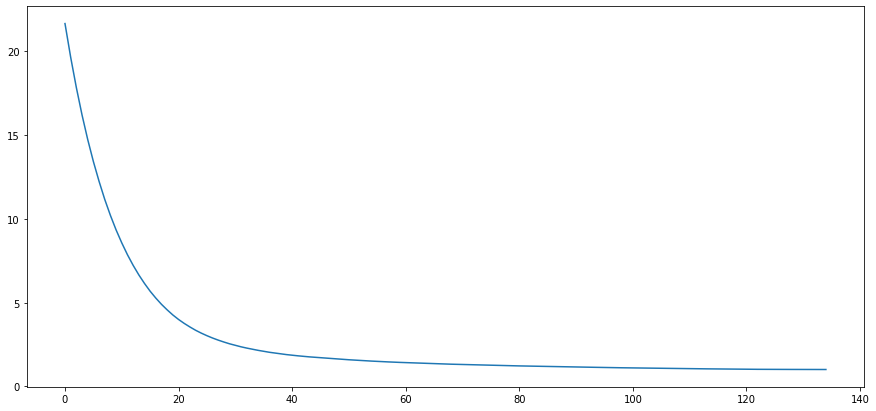

In [13]:
result['train-rmse-mean'].plot(figsize=(15,7))
plt.show()

# Hyperparameter tuning in xgboost

In [14]:
from tqdm import tqdm # progress bar

In [15]:
gridsearch_params = [
    (max_depth,learning_rate,alpha,min_child_weight)
    for max_depth in range(3,10)
    for learning_rate in np.arange(.1,1,.05)
    for alpha in range(5,7)
    for min_child_weight in range(6,10)
]

In [16]:
len(gridsearch_params)

1008

In [17]:
min_rmse = float('inf')
best_params = None

In [18]:
for max_depth,learning_rate,alpha,min_child_weight in tqdm(gridsearch_params):
    params['max_depth'] = max_depth
    params['learning_rate'] = learning_rate
    params['alpha'] = alpha
    params['min_child_weight'] = min_child_weight
    result = xgb.cv(params=params,
                    dtrain=data_matrix, 
                    num_boost_round=200, 
                    early_stopping_rounds=10, 
                    metrics='rmse',
                    seed = 0)

    mean_rmse = result['test-rmse-mean'].min()
    boost_rounds = result['test-rmse-mean'].argmin()
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,learning_rate,alpha,min_child_weight)

100%|██████████| 1008/1008 [02:50<00:00,  5.92it/s]


In [19]:
print(f"BEST PARAM for Regression {best_params}\n with RMSE {min_rmse:.3f}")

BEST PARAM for Regression (3, 0.25000000000000006, 6, 7)
 with RMSE 3.343


In [20]:
params['max_depth'] = best_params[0]
params['learning_rate'] = best_params[1]
params['alpha'] = best_params[2]
params['min_child_weight'] = best_params[3]

# Model training

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,random_state=0)
dtrain = xgb.DMatrix(data=xtrain,label=ytrain)
dtest = xgb.DMatrix(data=xtest,label=ytest)

In [23]:
model = xgb.train(params=params,
                  dtrain=dtrain,
                  num_boost_round=200,
                  evals=[(dtest,'Test')],
                  early_stopping_rounds=10)

[0]	Test-rmse:18.33386
[1]	Test-rmse:14.50592
[2]	Test-rmse:11.61715
[3]	Test-rmse:9.51521
[4]	Test-rmse:8.04114
[5]	Test-rmse:7.02409
[6]	Test-rmse:6.40340
[7]	Test-rmse:5.97483
[8]	Test-rmse:5.62988
[9]	Test-rmse:5.43670
[10]	Test-rmse:5.34155
[11]	Test-rmse:5.27580
[12]	Test-rmse:5.23374
[13]	Test-rmse:5.13348
[14]	Test-rmse:5.04700
[15]	Test-rmse:4.89151
[16]	Test-rmse:4.86250
[17]	Test-rmse:4.84482
[18]	Test-rmse:4.84048
[19]	Test-rmse:4.77265
[20]	Test-rmse:4.76517
[21]	Test-rmse:4.73580
[22]	Test-rmse:4.71992
[23]	Test-rmse:4.70866
[24]	Test-rmse:4.72242
[25]	Test-rmse:4.68134
[26]	Test-rmse:4.67942
[27]	Test-rmse:4.67239
[28]	Test-rmse:4.65780
[29]	Test-rmse:4.65775
[30]	Test-rmse:4.64392
[31]	Test-rmse:4.63464
[32]	Test-rmse:4.62694
[33]	Test-rmse:4.62217
[34]	Test-rmse:4.62083
[35]	Test-rmse:4.61812
[36]	Test-rmse:4.62034
[37]	Test-rmse:4.62953
[38]	Test-rmse:4.62963
[39]	Test-rmse:4.62607
[40]	Test-rmse:4.62365
[41]	Test-rmse:4.59601
[42]	Test-rmse:4.57853
[43]	Test-rmse:4.5

In [24]:
model.best_iteration

124

In [25]:
model.save_model('../models/boston_house_pricing.model')

# Load model

In [26]:
boston_model = xgb.Booster()
boston_model.load_model('../models/boston_house_pricing.model')

 # Prediction

In [27]:
ypred = boston_model.predict(data_matrix)

In [28]:
df['prediction'] = ypred

In [29]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price,prediction
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,25.103773
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,20.857807
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,34.164230
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,33.812775
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,35.337910
